In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

# 1. Imports

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# data preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# DL
import tensorflow as tf
from tensorflow import keras

# Model Metrics and Evaluation 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Model Saving
import pathlib
import shutil
import tempfile
logdir = pathlib.Path(tempfile.mktemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# tensorboard
import os
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

# 2. Import and Read Data

In [2]:
train = pd.read_csv('./data/spaceship-titanic/train.csv')
test = pd.read_csv('./data/spaceship-titanic/test.csv')
ss = pd.read_csv('./data/spaceship-titanic/sample_submission.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.shape

(8693, 14)

In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
test.shape

(4277, 13)

# 3. Data Descriptions

    PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    Destination - The planet the passenger will be debarking to.
    Age - The age of the passenger.
    VIP - Whether the passenger has paid for special VIP service during the voyage.
    RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    Name - The first and last names of the passenger.
    Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# 4. Exploratory Data Analysis

## 4.1 Data Types,  Missing Data, Summary Stats

In [6]:
train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 colu

In [7]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [8]:
test.nunique()

PassengerId     4277
HomePlanet         3
CryoSleep          2
Cabin           3265
Destination        3
Age               79
VIP                2
RoomService      842
FoodCourt        902
ShoppingMall     715
Spa              833
VRDeck           796
Name            4176
dtype: int64

In [9]:
train.isnull().sum() / len(train) * 100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [10]:
test.isnull().sum() / len(test) * 100

PassengerId     0.000000
HomePlanet      2.034136
CryoSleep       2.174421
Cabin           2.338087
Destination     2.151040
Age             2.127660
VIP             2.174421
RoomService     1.917232
FoodCourt       2.478373
ShoppingMall    2.291326
Spa             2.361468
VRDeck          1.870470
Name            2.197802
dtype: float64

In [12]:
# remove null values
train = train.fillna(method='pad')
test = test.fillna(method='pad')

In [13]:
train.shape

(8693, 14)

In [14]:
test.shape

(4277, 13)

## 4.2 Feature Analysis
### 4.2.1 Categorical Features

In [15]:
categorical_features = train.nunique()[train.nunique() < 10].index[:-1] # avoid including target variable
categorical_features

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], dtype='object')

### Home Planet

In [16]:
train['HomePlanet'].value_counts()

Earth     4720
Europa    2177
Mars      1796
Name: HomePlanet, dtype: int64

In [17]:
train[['HomePlanet', 'Transported']].groupby('HomePlanet', as_index=False).mean().sort_values(by='Transported', ascending=False)

,HomePlanet,Transported
1,Europa,0.659164
2,Mars,0.522829
0,Earth,0.424576


Text(0.5, 1.0, 'Transported Probability by Home Planet')

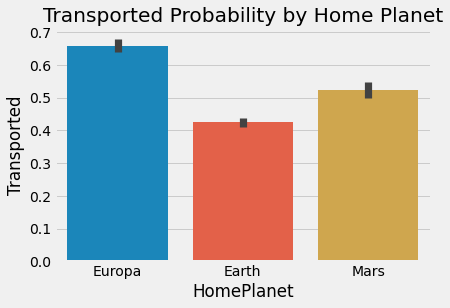

In [18]:
sns.barplot(x='HomePlanet', y='Transported', data=train)
plt.title('Transported Probability by Home Planet')

#### Notes:
Possible reasons for Europa having the highest tranportation risk are it is farthest from the sun, smallest, and  exists in a more turbulent environent (being a moon of Jupiter).

### Cryo Sleep

In [19]:
train['CryoSleep'].value_counts()

False    5582
True     3111
Name: CryoSleep, dtype: int64

In [20]:
train[['CryoSleep', 'Transported']].groupby('CryoSleep', as_index=False).mean().sort_values(by='Transported', ascending=False)

,CryoSleep,Transported
1,True,0.809065
0,False,0.333393


This is obviously a big difference in whether or not a Tranportation disaster took place.

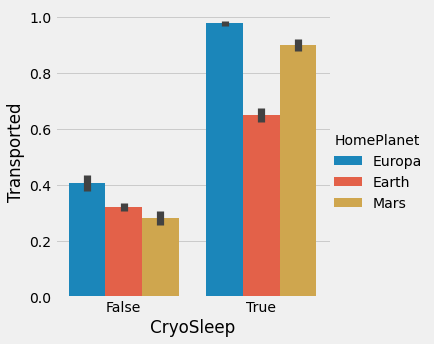

In [21]:
sns.catplot(x='CryoSleep', y='Transported', hue='HomePlanet', data=train, kind='bar')

In [22]:
train[train['CryoSleep'] == True]['Transported'].value_counts() / len(train[train['CryoSleep'] == True])

True     0.809065
False    0.190935
Name: Transported, dtype: float64

#### Note:
Cryosleep seems to be a huge factor in determining if someone was transported. Cryosleep passengers **are confined to their rooms** so it's important to get an idea if the event were localized in some way.

### Destination

In [23]:
train['Destination'].value_counts()

TRAPPIST-1e      6037
55 Cancri e      1840
PSO J318.5-22     816
Name: Destination, dtype: int64

In [24]:
train[['Destination', 'Transported']].groupby('Destination', as_index=False).mean().sort_values(by='Transported', ascending=False)

,Destination,Transported
0,55 Cancri e,0.609239
1,PSO J318.5-22,0.502451
2,TRAPPIST-1e,0.471592


Text(0.5, 1.0, 'Transported Probability by Destination')

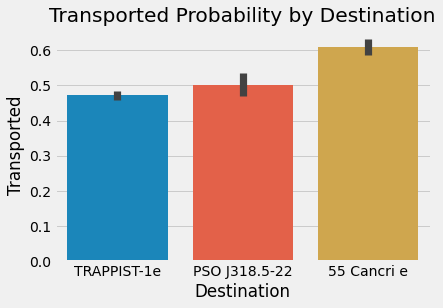

In [25]:
sns.barplot(x='Destination', y='Transported', data=train)
plt.title('Transported Probability by Destination')

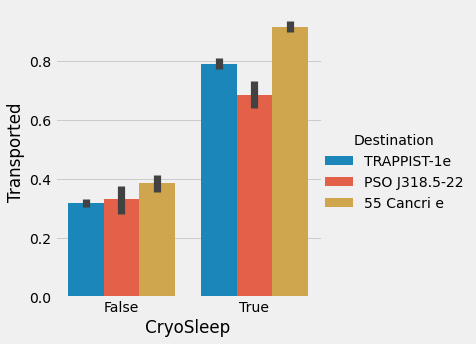

In [26]:
sns.catplot(x='CryoSleep', y='Transported', hue='Destination', data=train, kind='bar')

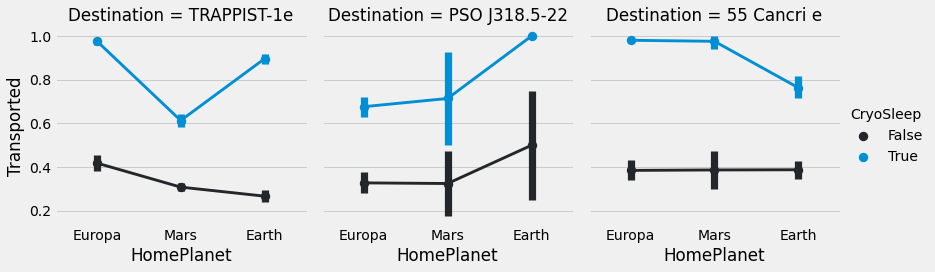

In [27]:
grid = sns.FacetGrid(train, col='Destination', size=4, aspect=1, )
grid.map(sns.pointplot, 'HomePlanet', 'Transported', 'CryoSleep', scale=0.4)
grid.add_legend(title='CryoSleep')

#### Note:
Destination may not play that important of a role.

### VIP

In [28]:
train['VIP'].value_counts()

False    8489
True      204
Name: VIP, dtype: int64

In [29]:
train[['VIP', 'Transported']].groupby('VIP', as_index=False).mean().sort_values(by='Transported', ascending=False)

,VIP,Transported
0,False,0.506302
1,True,0.392157


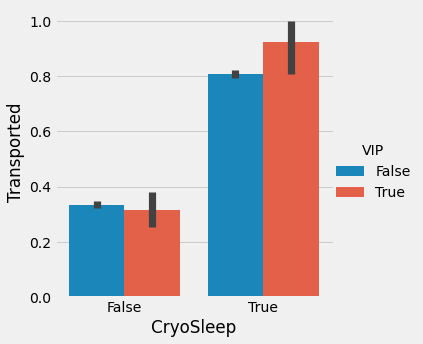

In [30]:
sns.catplot(x='CryoSleep', y='Transported', hue='VIP', data=train, kind='bar')

#### Note:
This seems to indicate the VIP is not that important to whether or not someone was tranported into another dimension.

### 4.2.2 Numerical Variables

In [31]:
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

### Age

Text(0.5, 1.0, 'Passenger Age Distribution by Tranported')

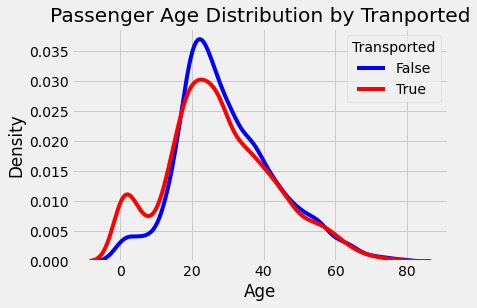

In [32]:
sns.kdeplot(train['Age'][train['Transported']==False], label='False', c='blue')
sns.kdeplot(train['Age'][train['Transported']==True], label='True', c='red')
plt.xlabel('Age')
plt.legend(title='Transported')
plt.title('Passenger Age Distribution by Tranported')

Text(0.5, 1.0, 'Average Ages of Tranported and\n Non-Transported Individuals by Home Planet')

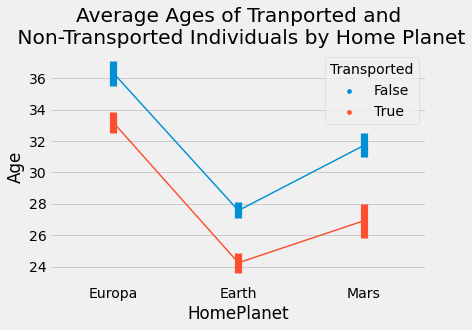

In [33]:
sns.pointplot(x='HomePlanet', y='Age', hue='Transported', data=train, scale=0.2)
plt.title('Average Ages of Tranported and\n Non-Transported Individuals by Home Planet')

Text(0.5, 1.0, 'Average Ages of Tranported and\n Non-Transported Individuals by Destination')

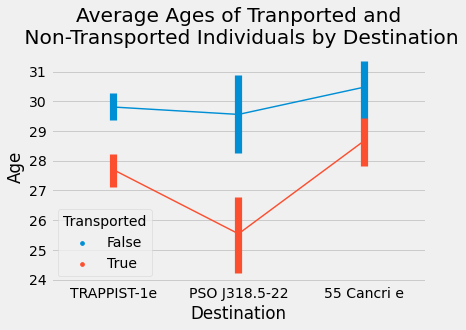

In [34]:
sns.pointplot(x='Destination', y='Age', hue='Transported', data=train, scale=0.2)
plt.title('Average Ages of Tranported and\n Non-Transported Individuals by Destination')

Text(0.5, 1.0, 'Average Ages of Tranported and\n Non-Transported Individuals by Cryo Sleep')

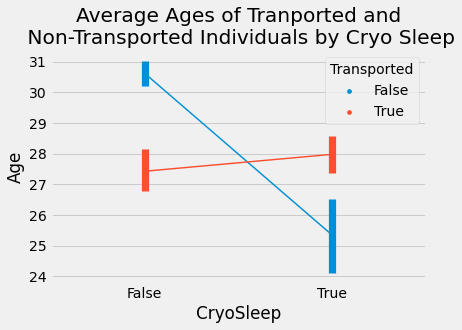

In [35]:
sns.pointplot(x='CryoSleep', y='Age', hue='Transported', data=train, scale=0.2)
plt.title('Average Ages of Tranported and\n Non-Transported Individuals by Cryo Sleep')

#### Note:
Even though the average age of those transported is younger, the average age of those who were tranported and in cryosleep is older. 

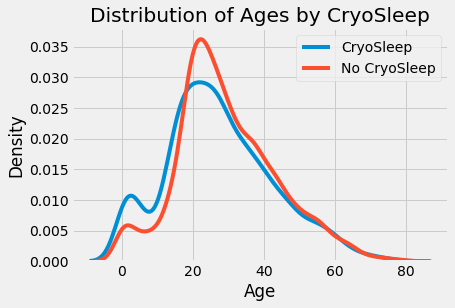

In [36]:
sns.kdeplot(x='Age', data = train[train['CryoSleep'] == True], label='CryoSleep')
sns.kdeplot(x='Age', data = train[train['CryoSleep'] == False], label='No CryoSleep')
plt.title('Distribution of Ages by CryoSleep')
plt.legend()

### Additional Costs

Text(0.5, 1.0, 'heatmap of expenses and transported for non-cryosleeping passengers')

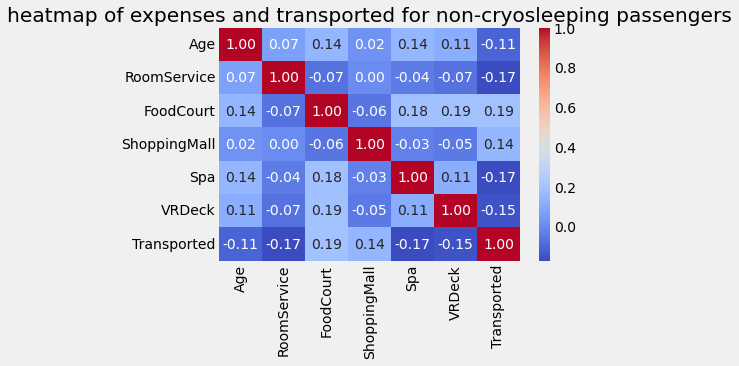

In [37]:
# remove cryolseeping passengers 

no_cryosleep = train[train['CryoSleep']==False] 
sns.heatmap(no_cryosleep[numerical_features + ['Transported']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('heatmap of expenses and transported for non-cryosleeping passengers')

In [38]:
purchases_encoded = no_cryosleep[numerical_features].applymap(lambda x: 1 if x > 0 else 0).drop('Age', axis=1)
summed_costs = no_cryosleep[numerical_features].drop('Age', axis=1).sum(axis=1)

#### Note:
Given that there is a weak correlation between where money was spent and when tranportation happened, it makes me wonder if the event has something to do with proximity. This would be difficult to text, but looking into the cabins a bit more may help reveal a stronger correlation for this.

In [39]:
was_transported = train[train['Transported'] == True]
not_transported = train[train['Transported'] == False]

In [40]:
was_transported[was_transported['CryoSleep'] == False].corr()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
CryoSleep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,1.000000,0.098292,0.094529,0.210928,0.057860,0.174122,0.160167,NaN
VIP,NaN,0.098292,1.000000,-0.025896,0.175572,-0.016392,0.140179,0.087263,NaN
RoomService,NaN,0.094529,-0.025896,1.000000,-0.038105,0.022296,-0.005652,-0.045482,NaN
FoodCourt,NaN,0.210928,0.175572,-0.038105,1.000000,-0.099072,0.233321,0.324332,NaN
ShoppingMall,NaN,0.057860,-0.016392,0.022296,-0.099072,1.000000,-0.015011,-0.053168,NaN
Spa,NaN,0.174122,0.140179,-0.005652,0.233321,-0.015011,1.000000,0.118193,NaN
VRDeck,NaN,0.160167,0.087263,-0.045482,0.324332,-0.053168,0.118193,1.000000,NaN
Transported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
not_transported[not_transported['CryoSleep'] == False]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
13,0010_01,Earth,False,G/1/S,TRAPPIST-1e,48.0,False,719.0,1.0,65.0,0.0,24.0,Reney Baketton,False
15,0012_01,Earth,False,F/2/P,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8674,9257_01,Earth,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False
8683,9272_02,Earth,False,F/1894/P,TRAPPIST-1e,21.0,False,86.0,3.0,149.0,208.0,329.0,Gordo Simson,False
8686,9275_02,Europa,False,A/97/P,TRAPPIST-1e,32.0,False,1.0,1146.0,0.0,50.0,34.0,Diram Conable,False
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False


What is known is that there are a larger number of passengers that were transported during cryosleep. Assuming that the event is localized to a certain location, and noting that the cryosleep passengers are confided to their cabins, it is worth looking into the locations of the cabins before moving onto the passenger ID's to see if there are any identifiable patterns of interest.

# 5. Feature Engineering
1. From Cabin, can isolate 3 additional features: Cabin Deck, Cabin Number, and Cabin Side. 
2. From Passenger ID, can determine if passenger is alone or not.

### Cabins

In [42]:
train['CabinList'] = train['Cabin'].apply(lambda x: x.split('/'))
train = pd.concat([train, pd.DataFrame(train['CabinList'].to_list(), columns=['CabinDeck', 'CabinNum', 'CabinSide'])], axis=1)
train = train.drop(['Cabin', 'CabinList'], axis=1)

In [43]:
train[['CabinSide', 'Transported']].groupby('CabinSide').mean()

,Transported
CabinSide,
P,0.451703
S,0.554845


In [44]:
train[['CabinDeck', 'Transported']].groupby('CabinDeck').mean()

,Transported
CabinDeck,
A,0.500000
B,0.729763
C,0.676702
D,0.432990
E,0.361204
F,0.439059
G,0.516756
T,0.200000


In [45]:
train['CabinNum'] = train['CabinNum'].astype('int')
print(train[['CabinNum']].nunique())
print(train[['CabinNum']].value_counts())

CabinNum    1817
dtype: int64
CabinNum
82          28
19          24
86          22
176         21
97          21
            ..
1670         1
1671         1
1672         1
1673         1
1894         1
Length: 1817, dtype: int64


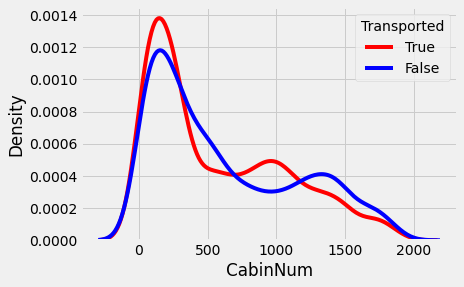

In [46]:
sns.kdeplot(x='CabinNum', data=train[train['Transported'] == True], label='True', c='red')
sns.kdeplot(x='CabinNum', data=train[train['Transported'] == False], label='False', c='blue')
plt.legend(title='Transported')
plt.show()

In [47]:
train['CabinDeck'].value_counts()

F    2847
G    2626
E     897
B     803
C     764
D     485
A     266
T       5
Name: CabinDeck, dtype: int64

In [48]:
train[train['CabinDeck'] == 'B']['CabinSide'].value_counts()

S    439
P    364
Name: CabinSide, dtype: int64

### PassengerID

In [49]:
train['PassList'] = train['PassengerId'].apply(lambda x: x.split('_'))
train = pd.concat([train, pd.DataFrame(train['PassList'].to_list(), columns=['PassengerGrp', 'PassengerGrpId'])], axis=1)
train = train.drop(['PassList'], axis=1)
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,CabinDeck,CabinNum,CabinSide,PassengerGrp,PassengerGrpId
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0001,01
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,0002,01
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,0003,01
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S,0003,02
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S,0004,01


No handles with labels found to put in legend.


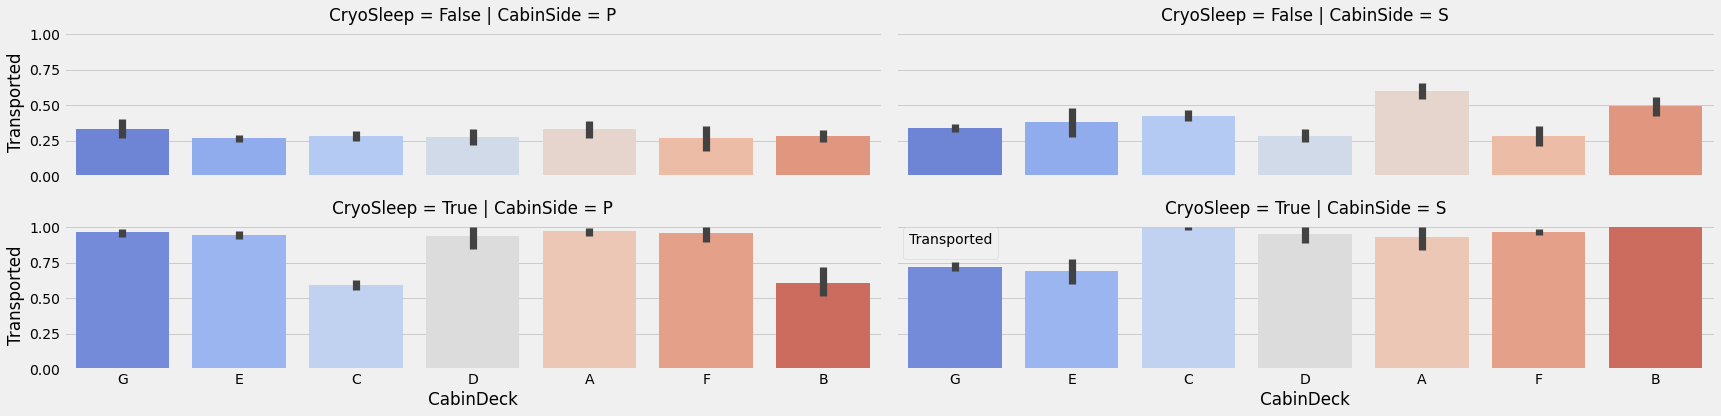

In [50]:
grid = sns.FacetGrid(data=train, row='CryoSleep', col='CabinSide', aspect=4, height=3)
grid.map(sns.barplot, 'CabinDeck', 'Transported', palette='coolwarm')
plt.legend(title='Transported')

<AxesSubplot:xlabel='CabinDeck,CabinSide'>

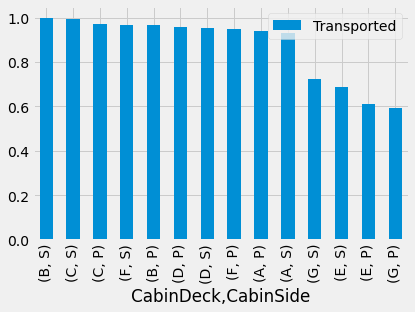

In [51]:
train[train['CryoSleep'] == True][['CabinDeck', 'CabinSide', 'Transported']].groupby(['CabinDeck', 'CabinSide']).mean().sort_values(by='Transported', ascending=False).plot(kind='bar')

<AxesSubplot:xlabel='CabinDeck,CabinSide'>

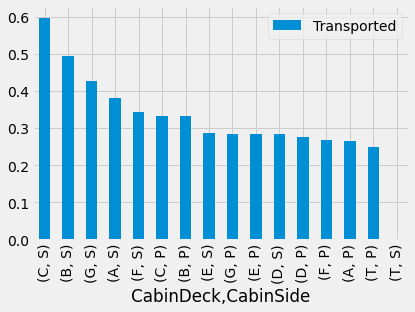

In [52]:
train[train['CryoSleep'] == False][['CabinDeck', 'CabinSide', 'Transported']].groupby(['CabinDeck', 'CabinSide']).mean().sort_values(by='Transported', ascending=False).plot(kind='bar')

In [53]:
train['PassengerGrpId'].value_counts()

01    6217
02    1412
03     571
04     231
05     128
06      75
07      46
08      13
Name: PassengerGrpId, dtype: int64

In [54]:
train[['PassengerGrpId', 'Transported']].groupby('PassengerGrpId', as_index=False).mean()

,PassengerGrpId,Transported
0,01,0.475953
1,02,0.558782
2,03,0.618214
3,04,0.593074
4,05,0.546875
5,06,0.546667
6,07,0.500000
7,08,0.461538


In [55]:
train[['PassengerGrpId', 'Transported']].groupby('PassengerGrpId', as_index=False).count()

,PassengerGrpId,Transported
0,01,6217
1,02,1412
2,03,571
3,04,231
4,05,128
5,06,75
6,07,46
7,08,13


In [56]:
train['TotalInvoice'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

<AxesSubplot:>

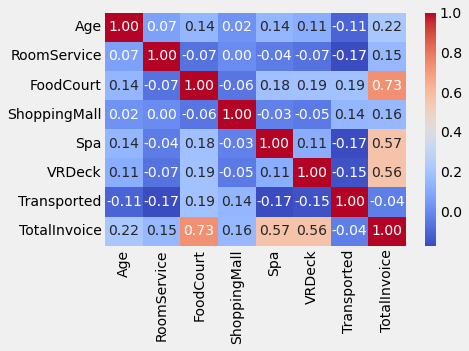

In [57]:
no_cryosleep = train[train['CryoSleep']==False] 
sns.heatmap(no_cryosleep[numerical_features + ['Transported', 'TotalInvoice']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

In [58]:
is_alone = train[['PassengerGrp','PassengerGrpId']].groupby('PassengerGrp').count()[train[['PassengerGrp','PassengerGrpId']].groupby('PassengerGrp').count() == 1].dropna().index
train['IsAlone'] = train['PassengerGrp'].apply(lambda x: 1 if x in is_alone else 0)

In [59]:
train[['IsAlone', 'Transported']].groupby('IsAlone').mean()

,Transported
IsAlone,
0,0.566872
1,0.452445


In [60]:
train[['IsAlone', 'CryoSleep']].groupby('IsAlone').count()

,CryoSleep
IsAlone,
0,3888
1,4805


In [61]:
pd.crosstab(train['Transported'], [train['IsAlone'].astype('bool'), train['CryoSleep']])

IsAlone     False        True      
CryoSleep   False  True False  True
Transported                        
False        1434   250  2287   344
True          865  1339   996  1178

# 6. Data Preprocessing

In [62]:
encoded_vars = pd.concat([pd.get_dummies(train[['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']]),
                          train[['CryoSleep', 'VIP']].astype('int'),
                          train['IsAlone']], axis=1)
scaler = Normalizer()
df_scaled = pd.DataFrame(scaler.fit_transform(train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'CabinNum']]), columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'CabinNum'])

In [63]:
df_preprocessed = pd.concat([encoded_vars, df_scaled], axis=1)
df_preprocessed

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,...,CabinSide_P,CabinSide_S,CryoSleep,VIP,IsAlone,Age,RoomService,FoodCourt,ShoppingMall,CabinNum
0,0,1,0,0,0,1,0,1,0,0,...,1,0,0,0,1,1.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0.209187,0.950056,0.078445,0.217903,0.000000
2,0,1,0,0,0,1,1,0,0,0,...,0,1,0,1,0,0.016216,0.012022,0.999796,0.000000,0.000000
3,0,1,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0.024701,0.000000,0.960350,0.277701,0.000000
4,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0.046233,0.875536,0.202269,0.436323,0.002890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,0,1,0,0,1,0,0,0,...,1,0,0,1,1,0.006012,0.000000,0.999879,0.000000,0.014370
8689,1,0,0,0,1,0,0,0,0,0,...,0,1,1,0,1,0.012007,0.000000,0.000000,0.000000,0.999928
8690,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0.010838,0.000000,0.000000,0.780335,0.625268
8691,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0.026383,0.000000,0.864880,0.000000,0.501284


In [64]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HomePlanet_Earth           8693 non-null   uint8  
 1   HomePlanet_Europa          8693 non-null   uint8  
 2   HomePlanet_Mars            8693 non-null   uint8  
 3   Destination_55 Cancri e    8693 non-null   uint8  
 4   Destination_PSO J318.5-22  8693 non-null   uint8  
 5   Destination_TRAPPIST-1e    8693 non-null   uint8  
 6   CabinDeck_A                8693 non-null   uint8  
 7   CabinDeck_B                8693 non-null   uint8  
 8   CabinDeck_C                8693 non-null   uint8  
 9   CabinDeck_D                8693 non-null   uint8  
 10  CabinDeck_E                8693 non-null   uint8  
 11  CabinDeck_F                8693 non-null   uint8  
 12  CabinDeck_G                8693 non-null   uint8  
 13  CabinDeck_T                8693 non-null   uint8

In [65]:
X_train, X_val, y_train, y_val = train_test_split(df_preprocessed, train['Transported'].astype('int'), test_size=0.2)

In [66]:
X_train.shape

(6954, 24)

In [67]:
X_val.shape

(1739, 24)

# Modeling

In [68]:
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

In [69]:
models = {
    'lr': LogisticRegression(),
          'sgd' : SGDClassifier(),
          'perc' : Perceptron(),
          'svm' : SVC(kernel='rbf'),
          'linear_svc' : SVC(kernel='linear'),
          'rf' : RandomForestClassifier(n_estimators=100),
          'gnb' : GaussianNB(),
          'cart' : DecisionTreeClassifier(),
          'cat': CatBoostClassifier(),
         }

In [70]:
def train_validation(models, X, y, validation_size, cv_num):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size)
    scores = {}
    print('model results\n')
    print('='*40)
    for model in models.items():
        cv = cross_val_score(model[1], X_train, y_train, cv=cv_num)
        y_pred = model[1].fit(X_train, y_train).predict(X_val)
        val = accuracy_score(y_val, y_pred)
        scores[model[0]] = (cv.mean(), val)
        print('-'*40)
        print('{} accuracy for {} training and validation sets:\n'.format(model[0], cv_num))
        print('mean training accuracy: {:.2f}'.format(cv.mean()))
        print('validation accuracy: {:.2f}'.format(val))
    return scores

# Deep Learning

In [71]:
def build_model(n_hidden=1, n_neurons=12, learning_rate=1e-3, input_shape=[24], dropout_rate=0.0):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
        model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [72]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden':np.arange(0,6),
    'n_neurons':np.arange(1,100),
    'learning_rate':np.logspace(-4,-1, 4),
    'dropout_rate':np.linspace(0.0, 0.5, 6)
}
# create wrapper around keras model
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)
cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, cv=3)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
#cv.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[tensorboard_cb])

In [73]:
# Feature Engineering for Test Set

test['CabinList'] = test['Cabin'].apply(lambda x: x.split('/'))
test = pd.concat([test, pd.DataFrame(test['CabinList'].to_list(), columns=['CabinDeck', 'CabinNum', 'CabinSide'])], axis=1)
test = test.drop(['Cabin', 'CabinList'], axis=1)
test['CabinNum'] = test['CabinNum'].astype('int')

test['PassList'] = test['PassengerId'].apply(lambda x: x.split('_'))
test = pd.concat([test, pd.DataFrame(test['PassList'].to_list(), columns=['PassengerGrp', 'PassengerGrpId'])], axis=1)
test = test.drop(['PassList'], axis=1)

is_alone = test[['PassengerGrp','PassengerGrpId']].groupby('PassengerGrp').count()[test[['PassengerGrp','PassengerGrpId']].groupby('PassengerGrp').count() == 1].dropna().index
test['IsAlone'] = test['PassengerGrp'].apply(lambda x: 1 if x in is_alone else 0)

encoded_vars = pd.concat([pd.get_dummies(test[['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']]),
                          test[['CryoSleep', 'VIP']].astype('int'),
                          test['IsAlone']], axis=1)
scaler = Normalizer()
df_scaled = pd.DataFrame(scaler.fit_transform(test[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'CabinNum']]), columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'CabinNum'])
X_test = pd.concat([encoded_vars, df_scaled], axis=1)
X_test

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,...,CabinSide_P,CabinSide_S,CryoSleep,VIP,IsAlone,Age,RoomService,FoodCourt,ShoppingMall,CabinNum
0,1,0,0,0,0,1,0,0,0,0,...,0,1,1,0,1,0.993884,0.000000,0.000000,0.000000,0.110432
1,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0.887812,0.000000,0.420542,0.000000,0.186908
2,0,1,0,1,0,0,0,0,1,0,...,0,1,1,0,1,1.000000,0.000000,0.000000,0.000000,0.000000
3,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0.005712,0.000000,0.999984,0.000000,0.000150
4,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0.031476,0.015738,0.000000,0.999350,0.007869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,0,0,0,0,1,0,0,0,0,...,0,1,1,0,0,0.022721,0.000000,0.000000,0.000000,0.999742
4273,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0.024422,0.000000,0.492519,0.009885,0.869903
4274,0,0,1,1,0,0,0,0,0,1,...,1,0,1,0,1,0.140485,0.000000,0.000000,0.000000,0.990083
4275,0,1,0,1,0,0,0,0,0,1,...,1,0,0,0,1,0.015574,0.000000,0.993795,0.000000,0.110133


In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_shape=[24], activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
model.fit(X_train, y_train, epochs=100, callbacks=[tensorboard_cb], validation_data=(X_val, y_val))

Epoch 1/100
218/218 [==============================] - 2s 4ms/step - loss: 0.6076 - accuracy: 0.6590 - val_loss: 0.5232 - val_accuracy: 0.7366
Epoch 2/100
218/218 [==============================] - 1s 4ms/step - loss: 0.5415 - accuracy: 0.7235 - val_loss: 0.5070 - val_accuracy: 0.7343
Epoch 3/100
218/218 [==============================] - 1s 4ms/step - loss: 0.5216 - accuracy: 0.7292 - val_loss: 0.5039 - val_accuracy: 0.7412
Epoch 4/100
218/218 [==============================] - 1s 4ms/step - loss: 0.5145 - accuracy: 0.7301 - val_loss: 0.5002 - val_accuracy: 0.7435
Epoch 5/100
218/218 [==============================] - 1s 5ms/step - loss: 0.5081 - accuracy: 0.7370 - val_loss: 0.5061 - val_accuracy: 0.7539
Epoch 6/100
218/218 [==============================] - 1s 4ms/step - loss: 0.5052 - accuracy: 0.7327 - val_loss: 0.4914 - val_accuracy: 0.7361
Epoch 7/100
218/218 [==============================] - 1s 4ms/step - loss: 0.5004 - accuracy: 0.7378 - val_loss: 0.4932 - val_accuracy: 0.7412

Epoch 58/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4520 - accuracy: 0.7754 - val_loss: 0.4702 - val_accuracy: 0.7562
Epoch 59/100
218/218 [==============================] - 1s 6ms/step - loss: 0.4540 - accuracy: 0.7719 - val_loss: 0.4764 - val_accuracy: 0.7522
Epoch 60/100
218/218 [==============================] - 1s 4ms/step - loss: 0.4518 - accuracy: 0.7751 - val_loss: 0.4666 - val_accuracy: 0.7585
Epoch 61/100
218/218 [==============================] - 1s 4ms/step - loss: 0.4514 - accuracy: 0.7742 - val_loss: 0.4699 - val_accuracy: 0.7596
Epoch 62/100
218/218 [==============================] - 1s 7ms/step - loss: 0.4512 - accuracy: 0.7722 - val_loss: 0.4704 - val_accuracy: 0.7573
Epoch 63/100
218/218 [==============================] - 1s 4ms/step - loss: 0.4528 - accuracy: 0.7722 - val_loss: 0.4694 - val_accuracy: 0.7533
Epoch 64/100
218/218 [==============================] - 1s 4ms/step - loss: 0.4495 - accuracy: 0.7767 - val_loss: 0.4709 - val_accuracy:

In [76]:
y_proba = model.predict(X_test)
y_pred = y_proba > 0.5
submission = test[['PassengerId']]
submission['Transported'] = y_pred
submission.to_csv('./submissions/submission.csv', index=False)